In [71]:
import os
import glob
import re
import numpy as np
import numpy.fft as fft
import mne
import matplotlib.pyplot as plt
from scipy import stats, signal
from numpy import save, load
import pandas as pd
import sklearn
from imblearn.over_sampling import SMOTE 
from sklearn.svm import SVC


In [72]:
import imblearn

### read dataset X and Y

In [73]:
def read_patient_file(base_path,subject_id,fileno):

    X=load('{}/data_chb{:02d}/features_{}_{:02d}.npy'.format(base_path,subject_id,subject_id, fileno))
    y=load('{}/data_chb{:02d}/targets_{}_{:02d}.npy'.format(base_path,subject_id,subject_id, fileno))
    
    return X,y

In [74]:
# selected_files_train={1:[2,10,14,15,17,20,30],3:[0,1,2,3,33,34,11,16],7:[11,12,2],8:[0,3,5,7,12],10:[16,19,23,1],5:[5,12,15,30], 15:[14,24,31,35,27],22:[16,21,4]}
# selected_files_test={1:[25,27],3:[35,27],7:[18,16],8:[15,19],10:[24,13],5:[21,36],15:[38],22:[27,24], 9:[10,5,6,7,11]}

In [75]:
# 
#  selected_files_train={1:[2,10,14,15,17,20,30],3:[0,10],7:[11,2],8:[0,11],10:[21,23,1,3],5:[5,12,15,30],9:[1,5], 15:[0,28],22:[16,1],23:[7,3],17:[18,0],18:[0,34]}
    # selected_files_test={1:[25,29],3:[33,12],7:[18,3],8:[15,19],10:[16,19,0,2],5:[21,36],15:[4,26],22:[27,0], 9:[18,13],23:[0,8],17:[19,9],18:[1,28]} 
def read_data(base_path,patients, test=False):
    selected_files_train={1:[2,10,14,15,17,20,30],3:[0,1,2,3,34,11,16],7:[11,2],8:[0,11],10:[21,23,1,3],5:[5,12,15,30],9:[1,5], 15:[0,28],22:[16,1],23:[7,3],17:[18,0],18:[0,34]}
    selected_files_test={1:[25,29],3:[33,12],7:[18,3],8:[15,19],10:[16,19,0,2],5:[21,36],15:[4,26],22:[27,0], 9:[18,13],23:[0,8],17:[19,9],18:[1,28]}   
    file_dict={}
    fileidx=0
    if test:
        selected_files_train=selected_files_test
    # print(base_path,patients[0],selected_files_train[patients[0]][0])
    Xnp,ynp=read_patient_file(base_path,patients[0],selected_files_train[patients[0]][0])
    file_dict[fileidx]=len(Xnp)
    fileidx+=1
    for fileno1 in selected_files_train[patients[0]][1:]:
        X_add, y_add= read_patient_file(base_path,patients[0],fileno1)
        Xnp=np.concatenate((Xnp,X_add))
        ynp=np.concatenate((ynp,y_add))
        file_dict[fileidx]=len(Xnp)
        # print(len(ynp))
        fileidx+=1
    for subject_id in (patients[1:]):
        for fileno in (selected_files_train[subject_id]):
                X_add, y_add= read_patient_file(base_path,subject_id,fileno)
                # print(X_add.shape)
                Xnp=np.concatenate((Xnp,X_add))
                ynp=np.concatenate((ynp,y_add))
                file_dict[fileidx]=len(Xnp)
                fileidx+=1
    return Xnp,ynp, file_dict
    


In [76]:
X_train,y_train, files_train=read_data('10sec_notwelch',[3,5,7,8,9,10,17,18,22,23])
print(X_train.shape,y_train.shape)
Xsum_train,ysum_train, sumfiles_train=read_data('zero_crossings',[3,5,7,8,9,10,17,18,22,23])
print(Xsum_train.shape,ysum_train.shape)

(36922, 208) (36922,)
(18372, 45) (18372,)


In [77]:
# files_train

In [78]:
def generate_column_names():
    channel_order= {'FP1-F7':0, 'F7-T7':1, 'T7-P7':2, 'P7-O1':3, 'FP1-F3':4, 'F3-C3':5, 'C3-P3':6, 'P3-O1':7, 'FP2-F4':8, 'F4-C4':9, 'C4-P4':10, 'P4-O2':11, 'FP2-F8':12, 'F8-T8':13, 'T8-P8-0':14, 'P8-O2':15, 'FZ-CZ':16, 'CZ-PZ':17, 'P7-T7':18, 'T7-FT9':19, 'FT9-FT10':20, 'FT10-T8':21 ,'T8-P8-1':22 }
    # channel_order= {0:'FP1-F7', 1:'F7-T7', 2:'T7-P7', 3:'P7-O1', 4:'FP1-F3', 5:'F3-C3', 6:'C3-P3', 7:'P3-O1', 8:'FP2-F4', 9:'F4-C4', 10:'C4-P4', 11:'P4-O2', 12:'FP2-F8', 13:'F8-T8', 14:'T8-P8', 15:'P8-O2', 16:'FZ-CZ', 17:'CZ-PZ', 18:'P7-T7', 19:'T7-FT9', 20:'FT9-FT10', 21:'FT10-T8' ,22:'T8-P8' }
    col_names=[]
    for ch in channel_order:
        # print(ch)
        for i in range(0,9):
            col_names.append(str(ch)+'-'+str(i))
    # col_names.append('rms')
    # col_names.append('sum')
    col_names.append('patient')
    # print(col_names.shape)
    return col_names


In [79]:
df_sums =pd.DataFrame(data=Xsum_train )
df_sums

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1261.0,2375.0,1251.0,2280.0,1247.0,2326.0,1246.0,2258.0,1257.0,2398.0,...,2264.0,1242.0,2326.0,1247.0,2428.0,1255.0,2349.0,1263.0,2396.0,3.0
1,1257.0,2350.0,1253.0,2295.0,1237.0,2236.0,1253.0,2269.0,1259.0,2396.0,...,2266.0,1230.0,2236.0,1245.0,2398.0,1243.0,2344.0,1253.0,2401.0,3.0
2,1261.0,2401.0,1255.0,2348.0,1253.0,2256.0,1261.0,2326.0,1271.0,2418.0,...,2303.0,1249.0,2256.0,1253.0,2392.0,1255.0,2386.0,1247.0,2397.0,3.0
3,1259.0,2435.0,1258.0,2346.0,1261.0,2348.0,1255.0,2347.0,1275.0,2438.0,...,2345.0,1265.0,2348.0,1253.0,2420.0,1263.0,2408.0,1254.0,2405.0,3.0
4,1251.0,2399.0,1258.0,2341.0,1255.0,2333.0,1243.0,2347.0,1271.0,2440.0,...,2311.0,1255.0,2333.0,1259.0,2427.0,1259.0,2400.0,1255.0,2423.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,1273.0,2452.0,1275.0,2521.0,1271.0,2506.0,1273.0,2501.0,1269.0,2450.0,...,2336.0,1271.0,2506.0,1275.0,2527.0,1273.0,2473.0,1275.0,2494.0,23.0
18368,1262.0,2432.0,1277.0,2519.0,1271.0,2520.0,1275.0,2481.0,1269.0,2427.0,...,2352.0,1273.0,2520.0,1273.0,2523.0,1263.0,2458.0,1271.0,2462.0,23.0
18369,1262.0,2425.0,1273.0,2517.0,1273.0,2531.0,1277.0,2473.0,1269.0,2423.0,...,2356.0,1273.0,2531.0,1273.0,2515.0,1257.0,2459.0,1265.0,2461.0,23.0
18370,1271.0,2439.0,1273.0,2513.0,1279.0,2513.0,1271.0,2471.0,1263.0,2448.0,...,2340.0,1279.0,2513.0,1277.0,2517.0,1263.0,2455.0,1269.0,2491.0,23.0


In [80]:
df=pd.DataFrame(data=X_train, columns=generate_column_names())

df=df.drop(['T8-P8-1-0', 'T8-P8-1-1', 'T8-P8-1-2', 'T8-P8-1-3', 'T8-P8-1-4', 'T8-P8-1-5', 'T8-P8-1-6', 'T8-P8-1-7', 'T8-P8-1-8'], axis=1)

# df['sum']=df_sums['sum']
# df['rms']=df_sums['rms']
for col in df_sums.columns[:-1]:
    df[col]=df_sums[col]

# df=df.drop(generate_column_names(), axis=1)

df['target']=y_train
df['file']=files_train[0]
for i in range(1,len(files_train)):
    print(files_train[i])
    df['file'][max(0, files_train[i-1]):files_train[i]]=files_train[i]
print(df.shape)
df=df.dropna()
print(df.shape)
df.reset_index(drop=True, inplace=True)

1427
2141
2854
3566
4284
5002
5716
6431
7143
7861
10732
13610
14324
15042
17920
20790
22225
23655
25093
26531
27249
27961
28741
29748
30460
31178
34056
36922
(36922, 245)


C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


(18372, 245)


In [81]:
df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,36,37,38,39,40,41,42,43,target,file
0,0.048201,0.157622,0.102184,0.059907,0.212427,0.065740,0.299087,0.061449,306.631836,0.066712,...,1242.0,2326.0,1247.0,2428.0,1255.0,2349.0,1263.0,2396.0,2,715
1,0.046769,0.158111,0.102100,0.060788,0.250879,0.057868,0.271288,0.059697,315.222168,0.059275,...,1230.0,2236.0,1245.0,2398.0,1243.0,2344.0,1253.0,2401.0,2,715
2,0.020402,0.162911,0.069030,0.031672,0.274410,0.059100,0.285805,0.080117,238.446213,0.056112,...,1249.0,2256.0,1253.0,2392.0,1255.0,2386.0,1247.0,2397.0,2,715
3,0.019260,0.153968,0.106827,0.035857,0.247914,0.059991,0.281614,0.078994,189.872879,0.049146,...,1265.0,2348.0,1253.0,2420.0,1263.0,2408.0,1254.0,2405.0,2,715
4,0.025350,0.173266,0.111380,0.043829,0.198319,0.056620,0.308731,0.071359,174.227905,0.032688,...,1255.0,2333.0,1259.0,2427.0,1259.0,2400.0,1255.0,2423.0,2,715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,0.085293,0.300186,0.009631,0.045827,0.186427,0.055777,0.233871,0.080660,872.280518,0.057423,...,1271.0,2506.0,1275.0,2527.0,1273.0,2473.0,1275.0,2494.0,0,20790
18368,0.050398,0.201367,0.029533,0.046813,0.204760,0.058098,0.277503,0.114979,1761.599976,0.049679,...,1273.0,2520.0,1273.0,2523.0,1263.0,2458.0,1271.0,2462.0,0,20790
18369,0.037239,0.185969,0.021312,0.035851,0.183851,0.059705,0.304138,0.145206,2355.503906,0.036216,...,1273.0,2531.0,1273.0,2515.0,1257.0,2459.0,1265.0,2461.0,0,20790
18370,0.046446,0.210207,0.003639,0.015245,0.174890,0.047634,0.329808,0.133363,1647.370117,0.044007,...,1279.0,2513.0,1277.0,2517.0,1263.0,2455.0,1269.0,2491.0,0,20790


In [82]:
X_test,y_test,files_test=read_data('10sec_notwelch',[3,5,7,8,9,10,17,18,22,23], test=True)
print(X_test.shape,y_test.shape)
Xsum_test,ysum_test, sumfiles_test=read_data('zero_crossings',[3,5,7,8,9,10,17,18,22,23],test=True)
print(Xsum_test.shape,ysum_test.shape)

(26995, 208) (26995,)
(13441, 45) (13441,)


In [83]:
test_df_sums =pd.DataFrame(data=Xsum_test)
test_df_sums

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1248.0,2424.0,1263.0,2474.0,1273.0,2489.0,1275.0,2504.0,1253.0,2392.0,...,2539.0,1273.0,2489.0,1257.0,2454.0,1265.0,2470.0,1277.0,2470.0,3.0
1,1263.0,2398.0,1271.0,2474.0,1263.0,2477.0,1273.0,2466.0,1265.0,2418.0,...,2543.0,1267.0,2477.0,1263.0,2493.0,1269.0,2465.0,1271.0,2431.0,3.0
2,1263.0,2394.0,1271.0,2470.0,1259.0,2470.0,1273.0,2474.0,1259.0,2407.0,...,2551.0,1263.0,2470.0,1261.0,2461.0,1265.0,2467.0,1271.0,2437.0,3.0
3,1265.0,2463.0,1277.0,2507.0,1269.0,2489.0,1277.0,2513.0,1265.0,2455.0,...,2541.0,1269.0,2489.0,1271.0,2464.0,1265.0,2519.0,1273.0,2509.0,3.0
4,1259.0,2429.0,1269.0,2493.0,1267.0,2465.0,1273.0,2481.0,1263.0,2430.0,...,2543.0,1269.0,2465.0,1273.0,2450.0,1266.0,2486.0,1271.0,2471.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13436,1265.0,2464.0,1273.0,2453.0,1265.0,2477.0,1277.0,2493.0,1271.0,2433.0,...,2310.0,1263.0,2477.0,1271.0,2419.0,1267.0,2455.0,1259.0,2464.0,23.0
13437,1259.0,2435.0,1279.0,2472.0,1269.0,2495.0,1275.0,2473.0,1271.0,2426.0,...,2330.0,1271.0,2495.0,1269.0,2452.0,1271.0,2468.0,1265.0,2470.0,23.0
13438,1261.0,2416.0,1275.0,2465.0,1271.0,2486.0,1273.0,2474.0,1265.0,2445.0,...,2347.0,1273.0,2486.0,1264.0,2440.0,1265.0,2460.0,1263.0,2458.0,23.0
13439,1271.0,2467.0,1275.0,2466.0,1267.0,2458.0,1267.0,2487.0,1265.0,2435.0,...,2323.0,1271.0,2458.0,1261.0,2422.0,1267.0,2468.0,1265.0,2474.0,23.0


In [84]:
test_df=pd.DataFrame(data=X_test, columns=generate_column_names())

test_df=test_df.drop(['T8-P8-1-0', 'T8-P8-1-1', 'T8-P8-1-2', 'T8-P8-1-3', 'T8-P8-1-4', 'T8-P8-1-5', 'T8-P8-1-6', 'T8-P8-1-7', 'T8-P8-1-8'], axis=1)

# test_df['sum']=test_df_sums['sum']
# test_df['rms']=test_df_sums['rms']
for col in test_df_sums.columns[:-1]:
    test_df[col]=test_df_sums[col]
# test_df=test_df.drop(generate_column_names(), axis=1)
test_df['target']=y_test
test_df['file']=files_test[0]
for i in range(1,len(files_test)):
    print(files_test[i])
    test_df['file'][max(0, files_test[i-1]):files_test[i]]=files_test[i]
print(test_df.shape)
test_df=test_df.dropna()
print(test_df.shape)
test_df.reset_index(drop=True, inplace=True)


1431
2143
2861
5734
8612
9324
10047
11177
14058
15491
16925
18367
19805
20523
21241
22196
23077
23789
24507
25995
26995
(26995, 245)


C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(13436, 245)


In [85]:
df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,36,37,38,39,40,41,42,43,target,file
0,0.048201,0.157622,0.102184,0.059907,0.212427,0.065740,0.299087,0.061449,306.631836,0.066712,...,1242.0,2326.0,1247.0,2428.0,1255.0,2349.0,1263.0,2396.0,2,715
1,0.046769,0.158111,0.102100,0.060788,0.250879,0.057868,0.271288,0.059697,315.222168,0.059275,...,1230.0,2236.0,1245.0,2398.0,1243.0,2344.0,1253.0,2401.0,2,715
2,0.020402,0.162911,0.069030,0.031672,0.274410,0.059100,0.285805,0.080117,238.446213,0.056112,...,1249.0,2256.0,1253.0,2392.0,1255.0,2386.0,1247.0,2397.0,2,715
3,0.019260,0.153968,0.106827,0.035857,0.247914,0.059991,0.281614,0.078994,189.872879,0.049146,...,1265.0,2348.0,1253.0,2420.0,1263.0,2408.0,1254.0,2405.0,2,715
4,0.025350,0.173266,0.111380,0.043829,0.198319,0.056620,0.308731,0.071359,174.227905,0.032688,...,1255.0,2333.0,1259.0,2427.0,1259.0,2400.0,1255.0,2423.0,2,715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,0.085293,0.300186,0.009631,0.045827,0.186427,0.055777,0.233871,0.080660,872.280518,0.057423,...,1271.0,2506.0,1275.0,2527.0,1273.0,2473.0,1275.0,2494.0,0,20790
18368,0.050398,0.201367,0.029533,0.046813,0.204760,0.058098,0.277503,0.114979,1761.599976,0.049679,...,1273.0,2520.0,1273.0,2523.0,1263.0,2458.0,1271.0,2462.0,0,20790
18369,0.037239,0.185969,0.021312,0.035851,0.183851,0.059705,0.304138,0.145206,2355.503906,0.036216,...,1273.0,2531.0,1273.0,2515.0,1257.0,2459.0,1265.0,2461.0,0,20790
18370,0.046446,0.210207,0.003639,0.015245,0.174890,0.047634,0.329808,0.133363,1647.370117,0.044007,...,1279.0,2513.0,1277.0,2517.0,1263.0,2455.0,1269.0,2491.0,0,20790


In [86]:
df['file'].unique()

array([  715,  1427,  2141,  2854,  3566,  4284,  5002,  5716,  6431,
        7143,  7861, 10732, 13610, 14324, 15042, 17920, 20790],
      dtype=int64)

In [87]:
df[df['target']==2]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,36,37,38,39,40,41,42,43,target,file
0,0.048201,0.157622,0.102184,0.059907,0.212427,0.065740,0.299087,0.061449,306.631836,0.066712,...,1242.0,2326.0,1247.0,2428.0,1255.0,2349.0,1263.0,2396.0,2,715
1,0.046769,0.158111,0.102100,0.060788,0.250879,0.057868,0.271288,0.059697,315.222168,0.059275,...,1230.0,2236.0,1245.0,2398.0,1243.0,2344.0,1253.0,2401.0,2,715
2,0.020402,0.162911,0.069030,0.031672,0.274410,0.059100,0.285805,0.080117,238.446213,0.056112,...,1249.0,2256.0,1253.0,2392.0,1255.0,2386.0,1247.0,2397.0,2,715
3,0.019260,0.153968,0.106827,0.035857,0.247914,0.059991,0.281614,0.078994,189.872879,0.049146,...,1265.0,2348.0,1253.0,2420.0,1263.0,2408.0,1254.0,2405.0,2,715
4,0.025350,0.173266,0.111380,0.043829,0.198319,0.056620,0.308731,0.071359,174.227905,0.032688,...,1255.0,2333.0,1259.0,2427.0,1259.0,2400.0,1255.0,2423.0,2,715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14137,0.039222,0.226431,0.131068,0.065022,0.319107,0.044205,0.169953,0.031493,1569.771484,0.012587,...,1259.0,2293.0,1247.0,2234.0,1245.0,2346.0,1235.0,2191.0,2,14324
14138,0.047177,0.223053,0.119125,0.075660,0.308506,0.038964,0.168055,0.026965,1795.059814,0.017723,...,1260.0,2346.0,1245.0,2315.0,1253.0,2357.0,1241.0,2261.0,2,14324
14139,0.034278,0.198490,0.143119,0.091086,0.308940,0.045564,0.158215,0.030277,2745.353516,0.012337,...,1246.0,2313.0,1242.0,2260.0,1250.0,2336.0,1233.0,2263.0,2,14324
14140,0.022747,0.210371,0.093604,0.047805,0.329353,0.054147,0.206286,0.038143,2986.209473,0.009048,...,1237.0,2222.0,1245.0,2198.0,1250.0,2312.0,1225.0,2220.0,2,14324


In [88]:
# for ind in df.index:
#     if df['target'].iloc[ind]==2 and df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (df['target'].iloc[i]==3) and df['file'].iloc[i]==df['file'].iloc[ind]:
#                 # print(df[['target','file']].iloc[i])
#                 df.at[i,'target']=2

# for ind in df.index:
#     if df['target'].iloc[ind]==2 and df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (df['target'].iloc[i]==3) and df['file'].iloc[i]==df['file'].iloc[ind]:
#                 # print(df[['target','file']].iloc[i])
#                 df.at[i,'target']=3

# for ind in df.index:
#     if df['target'].iloc[ind]==2 and df['target'].iloc[ind-1]==3:
#         for i in range(ind-120,ind-60):
#             if (df['target'].iloc[i]==3 or df['target'].iloc[i]==3) and df['file'].iloc[i]==df['file'].iloc[ind]:
#                 # print(df[['target','file']].iloc[i])
#                 df.at[i,'target']=4

In [89]:
# for ind in test_df.index:
#     if test_df['target'].iloc[ind]==2 and test_df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (test_df['target'].iloc[i]==3 or test_df['target'].iloc[i]==3) and test_df['file'].iloc[i]==test_df['file'].iloc[ind]:
#                 # print(test_df[['target','file']].iloc[i])
#                 test_df.at[i,'target']=2

# for ind in test_df.index:
#     if test_df['target'].iloc[ind]==2 and test_df['target'].iloc[ind-1]==3:
#         for i in range(ind-60,ind):
#             if (test_df['target'].iloc[i]==3 or test_df['target'].iloc[i]==3) and test_df['file'].iloc[i]==test_df['file'].iloc[ind]:
#                 # print(test_df[['target','file']].iloc[i])
#                 test_df.at[i,'target']=3

# for ind in test_df.index:
#     if test_df['target'].iloc[ind]==2 and test_df['target'].iloc[ind-1]==3:
#         for i in range(ind-120,ind-60):
#             if (test_df['target'].iloc[i]==3 or test_df['target'].iloc[i]==3) and test_df['file'].iloc[i]==test_df['file'].iloc[ind]:
#                 # print(test_df[['target','file']].iloc[i])
#                 test_df.at[i,'target']=4

In [90]:
for f in df['file'].unique():
    # print(f)
    temp_file_df=df[df['file']==f]
    if 2 in temp_file_df['target'].unique():
        # print(df[df['file']==f]['target'].unique())
        df['target'][(df['target']==0) & (df['file']==f)]=3
    # print(df[df['file']==f]['target'].unique())

for f in df['file'].unique():
    # print(f)
    temp_file_df=df[df['file']==f]
    if 2 in temp_file_df['target'].unique():
        for ind in range(temp_file_df.index.min(),temp_file_df.index.max()-1):
            # print('index'+str(ind)+"    "+str(len(temp_file_df)))
            if temp_file_df['target'].loc[ind]==2 and temp_file_df['target'].loc[ind+1]!=2:
                df['target'][ind+1:f]=3
        


C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Py

In [91]:
for f in test_df['file'].unique():
    # print(f)
    temp_file_df=test_df[test_df['file']==f]
    if 2 in temp_file_df['target'].unique():
        # print(test_df[test_df['file']==f]['target'].unique())
        test_df['target'][(test_df['target']==0) & (test_df['file']==f)]=3
    # print(test_df[test_df['file']==f]['target'].unique())
    
for f in test_df['file'].unique():
    # print(f)
    temp_file_df=test_df[test_df['file']==f]
    if 2 in temp_file_df['target'].unique():
        for ind in range(temp_file_df.index.min(),temp_file_df.index.max()-1):
            if temp_file_df['target'].loc[ind]==2 and temp_file_df['target'].loc[ind+1]!=2:
                test_df['target'][ind+1:f]=3
        

C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\salma\AppData\Roaming\Python\Py

In [92]:
# df['ratio']= df['sum']/df['rms']
# test_df['ratio']= test_df['sum']/test_df['rms']


In [93]:
df['target'].unique()

array([2, 3, 0], dtype=int64)

In [94]:
df['target'][225:343].unique()

array([3], dtype=int64)

### train test split

In [95]:
oneout=5

In [96]:
train_df=df
train_df=train_df[(train_df['target']==0) | (train_df['target']==2) | (train_df['target']==4)]
# train_df=train_df[(train_df['patient']!=oneout)]
# train_df=train_df.drop(['patient'], axis=1)



In [97]:
train_df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,36,37,38,39,40,41,42,43,target,file
0,0.048201,0.157622,0.102184,0.059907,0.212427,0.065740,0.299087,0.061449,306.631836,0.066712,...,1242.0,2326.0,1247.0,2428.0,1255.0,2349.0,1263.0,2396.0,2,715
1,0.046769,0.158111,0.102100,0.060788,0.250879,0.057868,0.271288,0.059697,315.222168,0.059275,...,1230.0,2236.0,1245.0,2398.0,1243.0,2344.0,1253.0,2401.0,2,715
2,0.020402,0.162911,0.069030,0.031672,0.274410,0.059100,0.285805,0.080117,238.446213,0.056112,...,1249.0,2256.0,1253.0,2392.0,1255.0,2386.0,1247.0,2397.0,2,715
3,0.019260,0.153968,0.106827,0.035857,0.247914,0.059991,0.281614,0.078994,189.872879,0.049146,...,1265.0,2348.0,1253.0,2420.0,1263.0,2408.0,1254.0,2405.0,2,715
4,0.025350,0.173266,0.111380,0.043829,0.198319,0.056620,0.308731,0.071359,174.227905,0.032688,...,1255.0,2333.0,1259.0,2427.0,1259.0,2400.0,1255.0,2423.0,2,715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18367,0.085293,0.300186,0.009631,0.045827,0.186427,0.055777,0.233871,0.080660,872.280518,0.057423,...,1271.0,2506.0,1275.0,2527.0,1273.0,2473.0,1275.0,2494.0,0,20790
18368,0.050398,0.201367,0.029533,0.046813,0.204760,0.058098,0.277503,0.114979,1761.599976,0.049679,...,1273.0,2520.0,1273.0,2523.0,1263.0,2458.0,1271.0,2462.0,0,20790
18369,0.037239,0.185969,0.021312,0.035851,0.183851,0.059705,0.304138,0.145206,2355.503906,0.036216,...,1273.0,2531.0,1273.0,2515.0,1257.0,2459.0,1265.0,2461.0,0,20790
18370,0.046446,0.210207,0.003639,0.015245,0.174890,0.047634,0.329808,0.133363,1647.370117,0.044007,...,1279.0,2513.0,1277.0,2517.0,1263.0,2455.0,1269.0,2491.0,0,20790


### train test split

In [98]:
test_df[test_df['target']==2]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,36,37,38,39,40,41,42,43,target,file
275,0.345117,0.215752,0.140790,0.227060,0.074075,0.019202,0.119332,0.023635,103.492218,0.332988,...,1239.0,2176.0,1231.0,2094.0,1237.0,2164.0,1229.0,2093.0,2,713
276,0.274128,0.174400,0.164891,0.208199,0.107044,0.025304,0.154591,0.026327,132.912552,0.125679,...,1221.0,2234.0,1220.0,2049.0,1243.0,2121.0,1224.0,2035.0,2,713
277,0.165978,0.135530,0.105011,0.087325,0.208076,0.056750,0.264505,0.044742,93.410263,0.045875,...,1234.0,2247.0,1225.0,2087.0,1243.0,2149.0,1225.0,2069.0,2,713
278,0.124761,0.144186,0.058100,0.087162,0.238440,0.054093,0.293636,0.051838,73.900223,0.094447,...,1239.0,2214.0,1228.0,2087.0,1223.0,2146.0,1216.0,2064.0,2,713
279,0.104311,0.177182,0.051509,0.085816,0.236868,0.060274,0.294471,0.057189,73.545120,0.138728,...,1239.0,2216.0,1218.0,2038.0,1225.0,2110.0,1225.0,2054.0,2,713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11093,0.040481,0.123594,0.121319,0.159624,0.257356,0.048418,0.230107,0.057496,1660.514893,0.015197,...,1269.0,2389.0,1265.0,2452.0,1259.0,2433.0,1217.0,2112.0,2,11177
11094,0.042015,0.115355,0.157368,0.168414,0.261393,0.042004,0.195699,0.046881,1695.156250,0.017442,...,1265.0,2413.0,1267.0,2460.0,1258.0,2449.0,1233.0,2140.0,2,11177
11095,0.068210,0.174970,0.185044,0.212418,0.251320,0.029909,0.128910,0.030331,2190.269775,0.045883,...,1265.0,2387.0,1269.0,2422.0,1261.0,2460.0,1229.0,2130.0,2,11177
11096,0.089601,0.208651,0.173917,0.217931,0.229105,0.031541,0.110607,0.031376,2034.920654,0.037177,...,1269.0,2341.0,1261.0,2417.0,1265.0,2433.0,1217.0,2129.0,2,11177


In [99]:
test_df2=test_df[(test_df['target']==0) | (test_df['target']==2) | (test_df['target']==4)]
# test_df2=test_df2[(test_df2['patient']==oneout)]

In [100]:
test_df2[test_df2['target']==2]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,36,37,38,39,40,41,42,43,target,file
1779,0.021233,0.080325,0.059098,0.075439,0.163324,0.042938,0.392880,0.168777,4650.898438,0.015522,...,1273.0,2487.0,1267.0,2457.0,1265.0,2489.0,1267.0,2475.0,2,2143
1780,0.007644,0.044882,0.019617,0.019416,0.159488,0.068403,0.501570,0.133567,24191.611328,0.007337,...,1271.0,2493.0,1271.0,2449.0,1269.0,2501.0,1267.0,2491.0,2,2143
1781,0.004853,0.054532,0.011449,0.011309,0.166997,0.072064,0.505813,0.133501,39400.445312,0.005021,...,1271.0,2483.0,1267.0,2435.0,1271.0,2455.0,1263.0,2477.0,2,2143
1782,0.004504,0.068042,0.009117,0.008221,0.177528,0.069905,0.474774,0.145581,32194.085938,0.003275,...,1275.0,2466.0,1267.0,2442.0,1271.0,2465.0,1262.0,2469.0,2,2143
1783,0.006321,0.065498,0.021163,0.017951,0.171265,0.066199,0.439794,0.161660,16816.226562,0.003533,...,1273.0,2482.0,1272.0,2457.0,1265.0,2498.0,1270.0,2493.0,2,2143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892,0.018577,0.228284,0.075439,0.058794,0.369578,0.059808,0.187530,0.025175,6316.443359,0.031000,...,1277.0,2495.0,1261.0,2478.0,1265.0,2458.0,1273.0,2519.0,2,2143
1893,0.014445,0.220031,0.041244,0.040488,0.430073,0.053464,0.178337,0.032415,9365.886719,0.029540,...,1279.0,2479.0,1263.0,2498.0,1257.0,2460.0,1273.0,2520.0,2,2143
1894,0.014800,0.185002,0.029280,0.038962,0.462727,0.039404,0.191139,0.042046,5615.968262,0.008603,...,1275.0,2477.0,1271.0,2495.0,1263.0,2463.0,1277.0,2499.0,2,2143
1895,0.032627,0.171664,0.088457,0.101287,0.277008,0.042625,0.262926,0.051297,2025.034302,0.004731,...,1267.0,2493.0,1273.0,2494.0,1269.0,2477.0,1275.0,2488.0,2,2143


In [101]:
test_df2['target'].unique()

array([2, 0], dtype=int64)

In [102]:
X_train1 = np.array(train_df.drop(['target','patient','file'], axis=1))
y_train1 = np.array(train_df['target'])
X_test1 = np.array(test_df2.drop(['target','patient','file'], axis=1)).astype('float32')
y_test1  =np.array(test_df2['target']).astype('float32')
# X_test = np.concatenate((X_test, X_interictal_test))
# y_test  =np.concatenate((y_test, y_interictal_test))

In [103]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train1, y_train1)
X_resampled_test, y_resampled_test = rus.fit_resample(X_test1, y_test1)


In [104]:
# sm = SMOTE(random_state=42, k_neighbors=3)
# X_resampled, y_resampled = sm.fit_resample(X_train1, y_train1)
# X_resampled_test, y_resampled_test = sm.fit_resample(X_test1, y_test1)



In [105]:
test_df.shape

(13436, 245)

In [106]:
X_train=np.array(X_resampled).astype('float32')
X_test=np.array( X_resampled_test).astype('float32')
y_train=np.array(y_resampled).astype('float32')
y_test=np.array( y_resampled_test).astype('float32')

X_train_shape =X_train.shape
X_test_shape = X_test.shape
y_train_shape =y_train.shape 
y_test_shape = y_test.shape
print(X_train_shape)
print(X_test_shape)
print(y_train_shape)
print(y_test_shape)

(1496, 242)
(236, 242)
(1496,)
(236,)


### Normalization

In [107]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# # scaler.fit(df.drop(['target', 'seizure_number', 'patient','mean_sum','mean_rms',	'sum_ratio','rms_ratio'], axis=1).append(test_df.drop(['target', 'seizure_number', 'patient','mean_sum','mean_rms',	'sum_ratio','rms_ratio'], axis=1), ignore_index=True))
# # scaler.fit(X_train)
Sc_X_train=scaler.fit_transform(X_train)
# # scaler.fit(X_test)
Sc_X_test=scaler.fit_transform(X_test)

In [108]:
# Sc_X_test=X_test
# Sc_X_train=X_train

In [109]:
X_train.shape

(1496, 242)

### PCA

In [110]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=150)
# Sc_X_train=pca.fit_transform(Sc_X_train)
# Sc_X_test=pca.transform(Sc_X_test)

### training the model

In [111]:
from datetime import datetime

In [112]:
cost: 150.0
weight_dict: {0: 1, 2: 10}

In [113]:
before = datetime.now()
before_time =before.strftime("%H:%M:%S")
print(before_time)

clf = SVC(C=1,kernel='rbf', random_state=42)
clf.fit(Sc_X_train, y_train)
trainAcc = clf.score(Sc_X_train, y_train)
testAcc = clf.score(Sc_X_test, y_test)
print("**SVM Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

after = datetime.now()
after_time =after.strftime("%H:%M:%S")
print(after_time)

16:38:06
**SVM Results:**
Training Accuracy: 96%
Testing Accuracy: 73%
16:38:07


In [114]:
after_time.translate({ord(i): '_' for i in ':'})


'16_38_07'

In [115]:
import joblib

#     # estimator = joblib.load("/my_models/%s.pkl"%dataset_name)
#     # print "using trained model"

# # print ("saving new model")
# joblib.dump(clf,"my_models/temporal{}_{}_{}.pkl".format(after_time[0:2],after_time[3:5],"f189"))

In [116]:
# clf = joblib.load("my_models/temporal00_54_C.pkl")
# y_pred=loaded_clf.predict(X_test)
y_pred=clf.predict(Sc_X_test)

In [117]:
def smooth(ser):
    window=7
    i=0
    while i < len(ser)-window:
        if ser[i]==ser[i+window]:
            ser[i:i+window]=ser[i]
        i+=1
    return np.array(ser)
clf.get_params(deep=True)

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [118]:
print(sklearn.metrics.classification_report(y_test, y_pred,))

              precision    recall  f1-score   support

         0.0       0.66      0.97      0.79       118
         2.0       0.94      0.51      0.66       118

    accuracy                           0.74       236
   macro avg       0.80      0.74      0.72       236
weighted avg       0.80      0.74      0.72       236



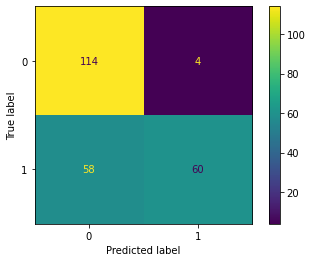

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [120]:
import statistics 
length=59
mode_pred=[]
mode_real=[]
for i in range(0,len(test_df2)-length, length):
    chunk=test_df2.iloc[int(i):int(i+length)]
    # print(list(chunk.columns))
    if(len(chunk['file'].unique())==1):
        chunk1 =scaler.fit_transform(chunk.drop(['file','patient','target'], axis=1))
        mode_pred.append(statistics.mode((clf.predict(np.array(chunk1)))))
        # print(y_test[int(block[0]):int(block[1])])
        mode_real.append(statistics.mode(chunk['target']))
    else:
        print(chunk['file'].unique())


In [121]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))

TN:114, FP:4, FN:58, TP:60


In [122]:
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_test, y_pred, average='micro')
auc=sklearn.metrics.roc_auc_score(y_test, y_pred)

print('specificity= {} , sensitivity= {}, f1= {}, auc={}'.format(specificity, sensitivity, f1_score, auc))

specificity= 0.9661016949152542 , sensitivity= 0.5084745762711864, f1= 0.7372881355932204, auc=0.7372881355932203


In [123]:
# import statistics 
# mode_pred=[]
# mode_real=[]
# for block in test_indices:
#     chunk = X_test1[int(block[0]):int(block[1])]
#     # print(len(chunk))
#     if len(chunk)>0:
#         chunk =scaler.fit_transform(chunk)

#         # print(clf.predict(np.array(chunk)))
#         mode_pred.append(statistics.mode((clf.predict(np.array(chunk)))))
#         # print(y_test[int(block[0]):int(block[1])])
#         mode_real.append(statistics.mode((y_test1[int(block[0]):int(block[1])])))

print(mode_pred)
print(mode_real)    # break

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [124]:
print(list(np.array(mode_pred)-np.array(mode_real)))


[-2.0, -2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


              precision    recall  f1-score   support

  interictal       0.86      1.00      0.92        12
    preictal       0.00      0.00      0.00         2

    accuracy                           0.86        14
   macro avg       0.43      0.50      0.46        14
weighted avg       0.73      0.86      0.79        14



C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


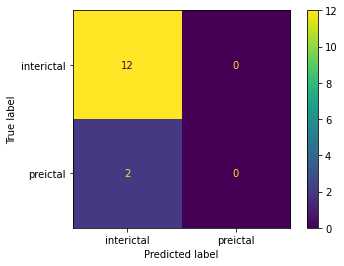

In [125]:
cm = confusion_matrix(mode_real, mode_pred,labels=[0,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interictal', 'preictal'])
disp.plot()
print(sklearn.metrics.classification_report(mode_real, mode_pred, labels=[0,2], target_names=['interictal', 'preictal']))

In [126]:
from sklearn.ensemble import RandomForestClassifier

rf_start = datetime.now()
print(rf_start)


rf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=70, class_weight='balanced')
rf.fit(Sc_X_train, y_train)
trainAcc=rf.score(Sc_X_train, y_train)
testAcc=rf.score(Sc_X_test, y_test)
print("**Random Forest Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

rf_finish = datetime.now()
rf_time =(rf_finish-rf_start)
print(rf_time)

2021-07-11 16:38:10.548001
**Random Forest Results:**
Training Accuracy: 100%
Testing Accuracy: 58%
0:00:01.970757


In [127]:
rf_y_pred=rf.predict(Sc_X_test)

In [128]:
print(sklearn.metrics.classification_report(y_test, rf_y_pred, labels=[0,2], target_names=['interictal', 'preictal']))

              precision    recall  f1-score   support

  interictal       0.54      1.00      0.70       118
    preictal       1.00      0.16      0.28       118

    accuracy                           0.58       236
   macro avg       0.77      0.58      0.49       236
weighted avg       0.77      0.58      0.49       236



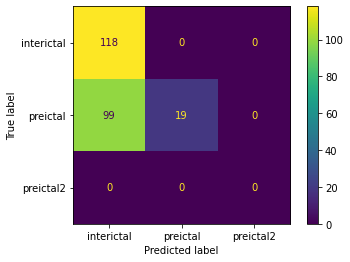

In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rf_y_pred,labels=[0,2,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interictal', 'preictal', 'preictal2'])
disp.plot()

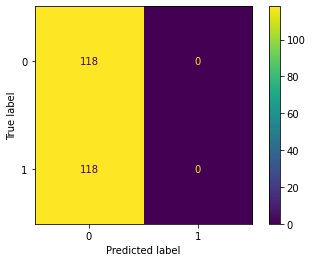

In [130]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, smooth(rf_y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [131]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, rf_y_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))

TN:118, FP:0, FN:118, TP:0


In [132]:
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_test, rf_y_pred, average='micro')

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

specificity= 1.0 , sensitivity= 0.0, f1= 0.5


In [133]:
# # print('X size ={}, y size = {}'.format(X_shape, y_shape))
# print('interictal size ={}, preictal size = {}'.format(interictal_shape, preictal_shape))
# print('train size ={}, test size = {}'.format(X_train_shape, X_test_shape))

# print("Training Accuracy: %d"%(trainAcc*100)+"%")
# print("Testing Accuracy: %d"%(testAcc *100)+"%")
# print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
# print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

In [134]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)

lr.fit(Sc_X_train, y_train)
trainAcc = lr.score(Sc_X_train, y_train)
testAcc = lr.score(Sc_X_test, y_test)
print("**SVM Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

**SVM Results:**
Training Accuracy: 99%
Testing Accuracy: 48%


C:\Users\salma\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

         0.0       0.49      0.66      0.56       118
         2.0       0.47      0.31      0.37       118

    accuracy                           0.48       236
   macro avg       0.48      0.48      0.47       236
weighted avg       0.48      0.48      0.47       236



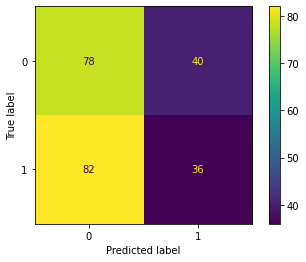

In [135]:
lr_y_pred=lr.predict(Sc_X_test)
print(sklearn.metrics.classification_report(y_test, lr_y_pred))

cm = confusion_matrix(y_test, lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [136]:
# def f_importances(coef, names):
#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()
# f_importances(clf.coef_, generate_column_names())

In [137]:
def drop_space(arr):
    new_arr=[]
    for el in arr:
        if el!='':
            new_arr.append(el)
    return new_arr
def report2rows(y_test,y_pred):
    split_table=str(sklearn.metrics.classification_report(y_test, y_pred)).split('\n')
    table2=[]*len(split_table)
    for st in split_table:
        st=st.strip()
        to_add=drop_space(st.split('  '))
        if len(to_add)>1:
            if drop_space(to_add)[0]=='accuracy':
                to_add=[to_add[0],'','',to_add[1],to_add[2]]
            if drop_space(to_add)[0]=='precision':
                to_add=['',to_add[0],to_add[1],to_add[2],to_add[3]]
            if drop_space(to_add)[0]=='2.0':
                to_add[0]='preictal'
            if drop_space(to_add)[0]=='0.0':
                to_add[0]='interictal'
            table2.append(to_add)
    return table2

In [138]:
def return_metrics(y_test,y_pred):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()
    specificity=(tn)/(tn+fp)
    sensitivity=(tp)/(tp+fn)
    f1_score=sklearn.metrics.f1_score(y_test, y_pred, average='micro')
    auc=sklearn.metrics.roc_auc_score(y_test, y_pred)

    return [list(sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()),[specificity, sensitivity, f1_score, auc]]

In [139]:
svm_pred=clf.predict(Sc_X_test)
rf_pred=rf.predict(Sc_X_test)
lr_pred=lr.predict(Sc_X_test)
import csv
with open('results_temp.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['10sec_notwelch'])
    writer.writerow(['periodogram','10','diff','frequency & Haare'])
    writer.writerow(["SVM"])
    writer.writerow(['TN',	'FP',	'FN',	'TP'])
    writer.writerow(return_metrics(y_test, svm_pred)[0])
    writer.writerow(['specificity','sensitivity','f1-score','auc'])
    writer.writerow(return_metrics(y_test, svm_pred)[1])
    writer.writerows(report2rows(y_test,clf.predict(Sc_X_test)))
    writer.writerow(["RF"])
    writer.writerow(['TN',	'FP',	'FN',	'TP'])
    writer.writerow(return_metrics(y_test, rf_pred)[0])
    writer.writerow(['specificity','sensitivity','f1-score','auc'])
    writer.writerow(return_metrics(y_test, rf_pred)[1])
    writer.writerows(report2rows(y_test,rf.predict(Sc_X_test)))
    writer.writerow(["LR"])
    writer.writerow(['TN',	'FP',	'FN',	'TP'])
    writer.writerow(return_metrics(y_test, lr_pred)[0])
    writer.writerow(['specificity','sensitivity','f1-score','auc'])
    writer.writerow(return_metrics(y_test, lr_pred)[1])
    writer.writerows(report2rows(y_test,lr.predict(Sc_X_test)))




PermissionError: [Errno 13] Permission denied: 'results_temp.csv'

# Testing on a new patient

In [ ]:
# df10=pd.DataFrame(data=X_10, columns=generate_column_names())
df10=df[df['patient']==9]
df10=df10[(df10['target']==2) | (df10['target']==0) ]
# df10['target']=y_10
# print(df10.shape)
# df10=df10.dropna()
# print(df10.shape)
# df10.reset_index(drop=True, inplace=True)
# df10=df10[(df10['target']==0) | (df10['target']==2)]
# print(df10['target'].max())
# df10=df10[(df10['patient']==10) ]
df10
# X_10_test  =np.array(test_df[df.columns[-1]]).astype('float32')


,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,28,30,32,34,36,38,40,42,target,file
20139,0.133061,0.408739,0.102874,0.128785,0.122062,0.026916,0.093007,0.028220,842.484741,0.085132,...,1269.0,1273.0,1265.0,1249.0,1273.0,1269.0,1263.0,1265.0,0,23017
20140,0.140891,0.466610,0.093273,0.097230,0.107099,0.030314,0.105131,0.030467,788.133667,0.025396,...,1271.0,1269.0,1257.0,1259.0,1265.0,1264.0,1267.0,1261.0,0,23017
20141,0.039498,0.141252,0.017832,0.022564,0.162640,0.051804,0.432038,0.117905,3364.845215,0.009816,...,1269.0,1265.0,1251.0,1255.0,1261.0,1268.0,1265.0,1265.0,0,23017
20142,0.014389,0.081509,0.004549,0.007157,0.143349,0.055358,0.405242,0.233103,12884.056641,0.005721,...,1269.0,1263.0,1261.0,1261.0,1271.0,1273.0,1257.0,1277.0,0,23017
20143,0.015849,0.085399,0.007605,0.010672,0.138365,0.055077,0.377824,0.251463,10708.702148,0.006997,...,1263.0,1265.0,1267.0,1257.0,1275.0,1273.0,1259.0,1265.0,0,23017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20895,0.016853,0.120981,0.013387,0.016764,0.163737,0.101336,0.396335,0.115579,7179.169434,0.007304,...,1275.0,1269.0,1262.0,1265.0,1271.0,1275.0,1273.0,1275.0,0,23017
20896,0.036440,0.137424,0.040018,0.047510,0.166479,0.062249,0.434888,0.059360,2143.101318,0.012932,...,1277.0,1271.0,1265.0,1257.0,1273.0,1273.0,1263.0,1271.0,0,23017
20897,0.024354,0.146653,0.027172,0.022556,0.202328,0.049001,0.421355,0.088137,4040.780762,0.009345,...,1271.0,1273.0,1265.0,1259.0,1273.0,1273.0,1257.0,1265.0,0,23017
20898,0.026473,0.177176,0.035278,0.029597,0.235778,0.047232,0.346527,0.093066,3295.840332,0.009262,...,1263.0,1273.0,1263.0,1261.0,1279.0,1277.0,1263.0,1269.0,0,23017


In [ ]:
df10['patient'].unique()

array([9.])

In [ ]:
df10=df10.drop(['patient'], axis=1)

In [ ]:
df10[df10.drop('target', axis=1).columns]

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,26,28,30,32,34,36,38,40,42,file
20139,0.133061,0.408739,0.102874,0.128785,0.122062,0.026916,0.093007,0.028220,842.484741,0.085132,...,1253.0,1269.0,1273.0,1265.0,1249.0,1273.0,1269.0,1263.0,1265.0,23017
20140,0.140891,0.466610,0.093273,0.097230,0.107099,0.030314,0.105131,0.030467,788.133667,0.025396,...,1267.0,1271.0,1269.0,1257.0,1259.0,1265.0,1264.0,1267.0,1261.0,23017
20141,0.039498,0.141252,0.017832,0.022564,0.162640,0.051804,0.432038,0.117905,3364.845215,0.009816,...,1267.0,1269.0,1265.0,1251.0,1255.0,1261.0,1268.0,1265.0,1265.0,23017
20142,0.014389,0.081509,0.004549,0.007157,0.143349,0.055358,0.405242,0.233103,12884.056641,0.005721,...,1269.0,1269.0,1263.0,1261.0,1261.0,1271.0,1273.0,1257.0,1277.0,23017
20143,0.015849,0.085399,0.007605,0.010672,0.138365,0.055077,0.377824,0.251463,10708.702148,0.006997,...,1263.0,1263.0,1265.0,1267.0,1257.0,1275.0,1273.0,1259.0,1265.0,23017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20895,0.016853,0.120981,0.013387,0.016764,0.163737,0.101336,0.396335,0.115579,7179.169434,0.007304,...,1273.0,1275.0,1269.0,1262.0,1265.0,1271.0,1275.0,1273.0,1275.0,23017
20896,0.036440,0.137424,0.040018,0.047510,0.166479,0.062249,0.434888,0.059360,2143.101318,0.012932,...,1271.0,1277.0,1271.0,1265.0,1257.0,1273.0,1273.0,1263.0,1271.0,23017
20897,0.024354,0.146653,0.027172,0.022556,0.202328,0.049001,0.421355,0.088137,4040.780762,0.009345,...,1265.0,1271.0,1273.0,1265.0,1259.0,1273.0,1273.0,1257.0,1265.0,23017
20898,0.026473,0.177176,0.035278,0.029597,0.235778,0.047232,0.346527,0.093066,3295.840332,0.009262,...,1265.0,1263.0,1273.0,1263.0,1261.0,1279.0,1277.0,1263.0,1269.0,23017


In [ ]:
X_10_test  =np.array(df10.drop('target', axis=1)).astype('float32')
y_10_test  =np.array(df10['target']).astype('float32')


In [ ]:
test_10=clf.predict(X_10_test)
test_10.shape

ValueError: X.shape[1] = 221 should be equal to 220, the number of features at training time

In [ ]:
tes_10_score = clf.score(X_10_test, y_10_test)
tes_10_score

ValueError: Found array with 0 sample(s) (shape=(0, 201)) while a minimum of 1 is required.

In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_10_test, test_10).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_10_test, test_10,pos_label=2)

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

TN:1561, FP:12462, FN:3, TP:403
specificity= 0.11131712187121158 , sensitivity= 0.9926108374384236, f1= 0.06073393112802352


In [ ]:
df_results16=pd.DataFrame({'real':y_10_test, 'predicted':test_10})
df_results16


,real,predicted
0,0.0,2.0
1,0.0,2.0
2,0.0,2.0
3,0.0,2.0
4,0.0,2.0
...,...,...
14424,0.0,2.0
14425,0.0,2.0
14426,0.0,2.0
14427,0.0,2.0


In [ ]:
def smooth(ser):
    window=5
    i=0
    while i < len(ser)-window:
        if ser[i]==ser[i+window]:
            ser[i:i+window]=ser[i]
        i+=1
    return np.array(ser)

In [ ]:
import statistics
def smooth_mode(ser):
    window=11
    i=0
    while i < len(ser)-window:
        ser[i:i+window]=statistics.mode(ser[i:i+window])
        i+=window
    return np.array(ser)

In [ ]:
smooth_pred=smooth(test_10)
smooth_pred

array([2., 2., 2., ..., 2., 2., 2.], dtype=float32)

In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_10_test, smooth_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_10_test, smooth_pred, pos_label=2)

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

TN:1321, FP:12702, FN:0, TP:406
specificity= 0.0942023818013264 , sensitivity= 1.0, f1= 0.060085836909871244


In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_10_test, smooth_mode(test_10)).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
f1_score=sklearn.metrics.f1_score(y_10_test, smooth_mode(test_10), pos_label=2)

print('specificity= {} , sensitivity= {}, f1= {}'.format(specificity, sensitivity, f1_score))

StatisticsError: no unique mode; found 2 equally common values

In [ ]:
stop

NameError: name 'stop' is not defined

### grid search

In [ ]:
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
balance = [{0:10,2:1}, {0:1,2:1}, {0:1,2:10}, {0:1,2:15}, {0:1,2:20}]
costs=[1.0,10.0,100.0, 150.0,1000.0]
# balance = [{0:1,2:10}, {0:1,2:15}]
# costs=[1.0]
param_grid = dict(C=costs, class_weight=balance)

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1_macro')


In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.548936 using {'C': 1000.0, 'class_weight': {0: 1, 2: 1}}
0.464987 (0.000025) with: {'C': 1.0, 'class_weight': {0: 10, 2: 1}}
0.464987 (0.000025) with: {'C': 1.0, 'class_weight': {0: 1, 2: 1}}
0.217273 (0.004215) with: {'C': 1.0, 'class_weight': {0: 1, 2: 10}}
0.202093 (0.005248) with: {'C': 1.0, 'class_weight': {0: 1, 2: 15}}
0.193375 (0.004963) with: {'C': 1.0, 'class_weight': {0: 1, 2: 20}}
0.467381 (0.001471) with: {'C': 10.0, 'class_weight': {0: 10, 2: 1}}
0.473319 (0.003141) with: {'C': 10.0, 'class_weight': {0: 1, 2: 1}}
0.269558 (0.003700) with: {'C': 10.0, 'class_weight': {0: 1, 2: 10}}
0.240071 (0.005545) with: {'C': 10.0, 'class_weight': {0: 1, 2: 15}}
0.219372 (0.005653) with: {'C': 10.0, 'class_weight': {0: 1, 2: 20}}
0.474830 (0.001837) with: {'C': 100.0, 'class_weight': {0: 10, 2: 1}}
0.491107 (0.004591) with: {'C': 100.0, 'class_weight': {0: 1, 2: 1}}
0.326736 (0.007160) with: {'C': 100.0, 'class_weight': {0: 1, 2: 10}}
0.263315 (0.005673) with: {'C': 100.0, 'cla